<a href="https://colab.research.google.com/github/PaulaGili/Financial-Default-Prediction/blob/main/FINANCIAL%20DEFAULT%20PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="1F4E79"><b>FINANCIAL DEFAULT PREDICTION</b></font>
---


#####<font color="B0B0B0"><b>Install Libraries</b></font>

In [ ]:
!pip install kagglehub
!pip install reportlab
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install scikit-learn
!pip install shap

#####<font color="B0B0B0"><b>Import Libraries</b></font>

In [ ]:
# System & File Handling
import os
import kagglehub
from google.colab import files
from google.colab import drive

# PDF Generation
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from matplotlib.backends.backend_pdf import PdfPages

# Data Handling & Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing & Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer  # Needed to enable IterativeImputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Evaluation Metrics
from sklearn.metrics import confusion_matrix

# Model Explainability
import shap

import nbformat
from nbconvert import HTMLExporter

###<font color="1F4E79"><b>1. Load and Explore Data</b></font> :

In [ ]:
# Download the credit risk dataset and print its file path
path = kagglehub.dataset_download("ranadeep/credit-risk-dataset")
print(f"File path: {path}")

File path: /kaggle/input/credit-risk-dataset


In [ ]:
# Assign the dataset path returned by kagglehub.dataset_download
dataset_path = path
print(os.listdir(dataset_path))

['loan', 'LCDataDictionary.xlsx']


In [ ]:
# Build file path for cross-platform compatibility
file_path_csv = os.path.join(path, "loan", "loan.csv")

In [ ]:
# Load the CSV file
df = pd.read_csv(file_path_csv)

<ipython-input-100-ef56dc3192b9>:2: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path_csv)


Inspect columns with mixed data types:

In [ ]:
# Display first few rows of column 19
print("Content of column 19:")
print(df.iloc[:, 19].head())

# Display first few rows of column 55
print("\nContent of column 55:")
print(df.iloc[:, 55].head())

Content of column 19:
0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
2                                                  NaN
3      Borrower added on 12/21/11 > to pay for prop...
4      Borrower added on 12/21/11 > I plan on combi...
Name: desc, dtype: object

Content of column 55:
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: verification_status_joint, dtype: object


In [ ]:
# Display names of the first 20 columns
print(df.columns[:20])

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc'],
      dtype='object')


In [ ]:
# Show first 3 rows
print(df.head(3).to_string(index=False, justify='center'))

   id    member_id   loan_amnt  funded_amnt  funded_amnt_inv    term     int_rate  installment grade sub_grade              emp_title              emp_length home_ownership  annual_inc  verification_status issue_d  loan_status pymnt_plan                                 url                                                                                                                                                                                                                                                                                                                                       desc                                                                                                                                                                                                                                                                                                           purpose                       title                 zip_code addr_state    dti    delinq_2yrs ear

In [ ]:
# Show DataFrame summary
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

In [ ]:
# View numeric columns in the DataFrame
numeric_columns = df.select_dtypes(include=['number']).columns
print("Numeric columns:", numeric_columns)

Numeric columns: Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m'],
      dtype='object')


In [ ]:
# Calculate the correlation matrix using only numeric columns
correlation_matrix = df[numeric_columns].corr()

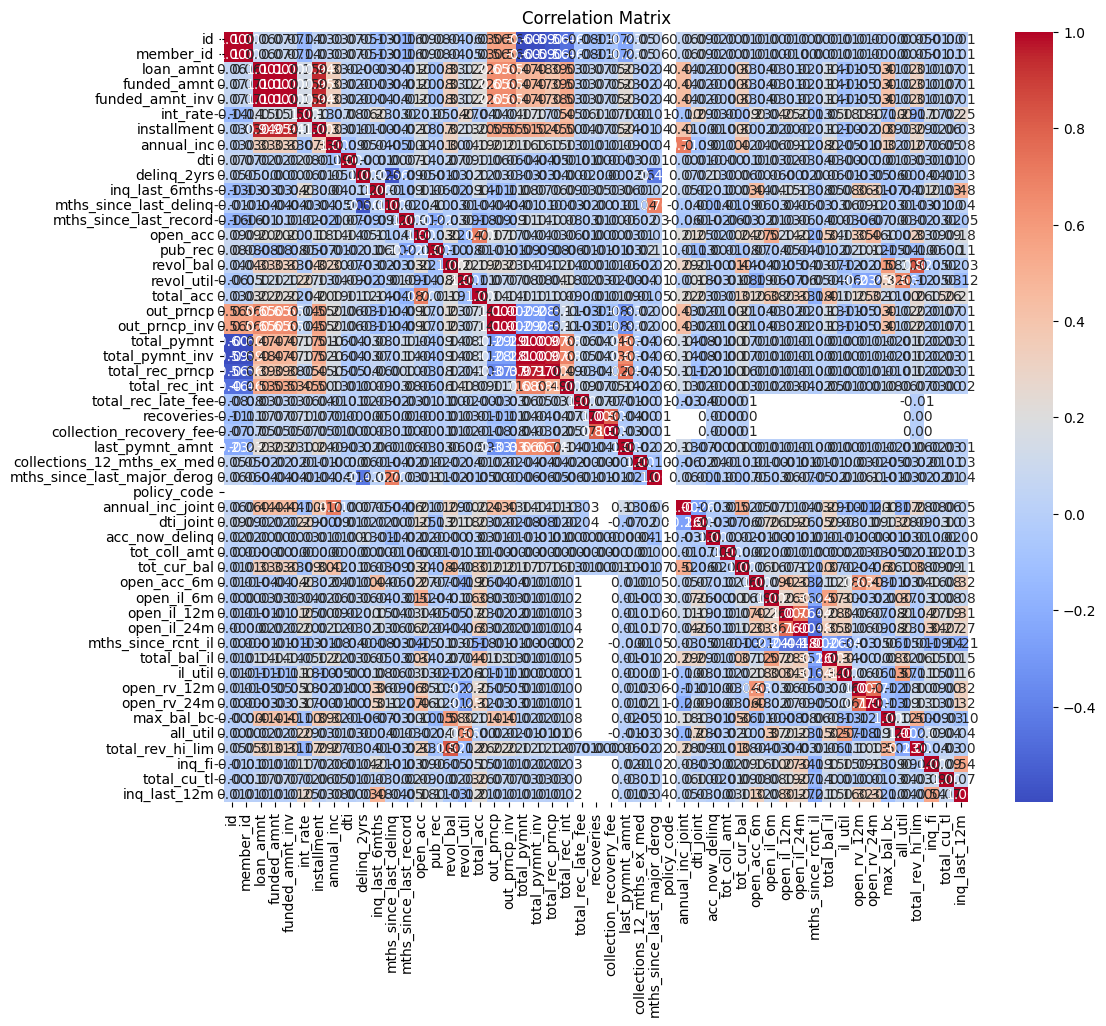

In [ ]:
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Create a mask where correlations are <= 0.9 or == 1 (self-correlation)
mask = (correlation_matrix <= 0.9) | (correlation_matrix == 1.0)

# Apply the mask to display only values > 0.9 and < 1
high_corr_matrix = correlation_matrix.mask(mask)

# Display the resulting matrix with correlations above 0.9
print("Correlations > 0.9 (without removing rows/columns):")
print(high_corr_matrix)

Correlations > 0.9 (without removing rows/columns):
                                 id  member_id  loan_amnt  funded_amnt  \
id                              NaN    0.99944        NaN          NaN   
member_id                   0.99944        NaN        NaN          NaN   
loan_amnt                       NaN        NaN        NaN      0.99926   
funded_amnt                     NaN        NaN    0.99926          NaN   
funded_amnt_inv                 NaN        NaN    0.99712      0.99803   
int_rate                        NaN        NaN        NaN          NaN   
installment                     NaN        NaN    0.94498      0.94600   
annual_inc                      NaN        NaN        NaN          NaN   
dti                             NaN        NaN        NaN          NaN   
delinq_2yrs                     NaN        NaN        NaN          NaN   
inq_last_6mths                  NaN        NaN        NaN          NaN   
mths_since_last_delinq          NaN        NaN        NaN   

###<font color="1F4E79"><b>2. Data Processing</b></font>

####<font color="1F4E79"><b>2.1 EDA and Visualizations</b></font>

######<font color="2980B9"><b>PDF Report: "output_graphs.pdf" – Pie Chart Distribution for Categorical Columns</b></font>

The DataFrame is filtered to retain only 'INDIVIDUAL' values in the `application_type` column, removing 'JOINT' records. Columns with "joint" in their names, along with the `application_type` column, are dropped.

Categorical variables with fewer than 10 categories, such as `verification_status`, `application_type`, `initial_list_status`, and `term`, are analyzed using pie charts to visualize category distributions.


In [ ]:
# Create PDF with pie charts for categorical columns
with PdfPages('output_graphs.pdf') as pdf:
    for col in df.columns:
        if df[col].nunique() < 10:
            # Set figure size based on category count
            num_categories = df[col].nunique()
            figsize = (7, 7) if num_categories <= 5 else (9, 7)
            plt.figure(figsize=figsize)

            # Define color palette
            colors = ['#003366', '#336699', '#6699CC', '#99CCFF', '#CCE5FF', '#B3C6FF', '#99A3FF', '#8090FF', '#5C7EFF']

            # Plot pie chart
            ax = df[col].value_counts().plot.pie(
                autopct='%1.1f%%',
                startangle=90,
                shadow=True,
                ylabel='',
                title=f'Distribution of {col}',
                colors=colors,
                legend=True,
                fontsize=12
            )

            # Add legend and adjust layout
            ax.legend(title='Categories', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
            plt.title(f'Distribution of {col}', fontsize=14)
            plt.tight_layout()

            # Save plot to PDF and close figure
            pdf.savefig()
            plt.close()

In [ ]:
# Download PDF
files.download("output_graphs.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* **Plot missing data by 'verification_status_joint':**

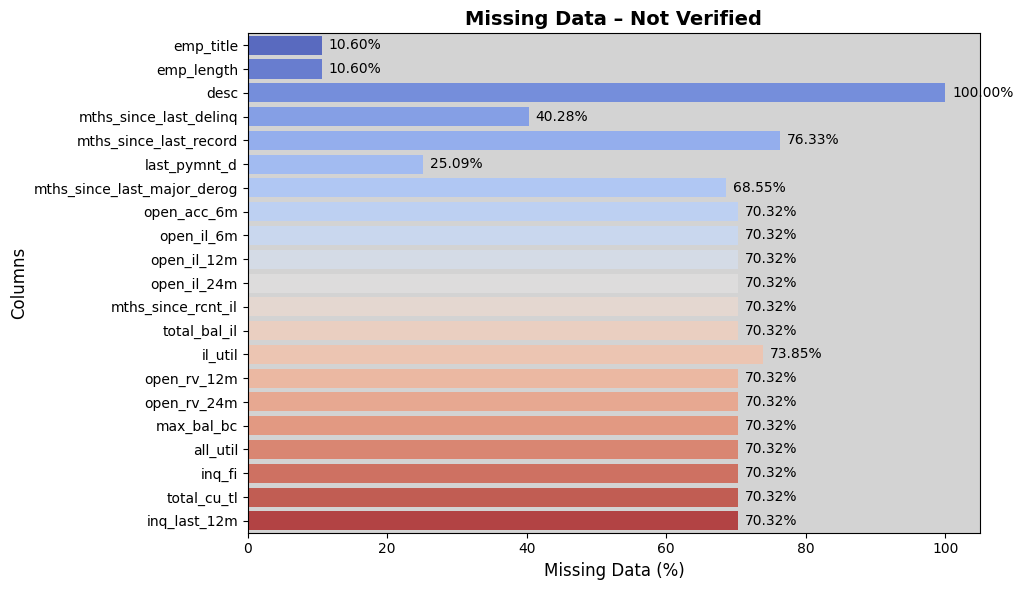

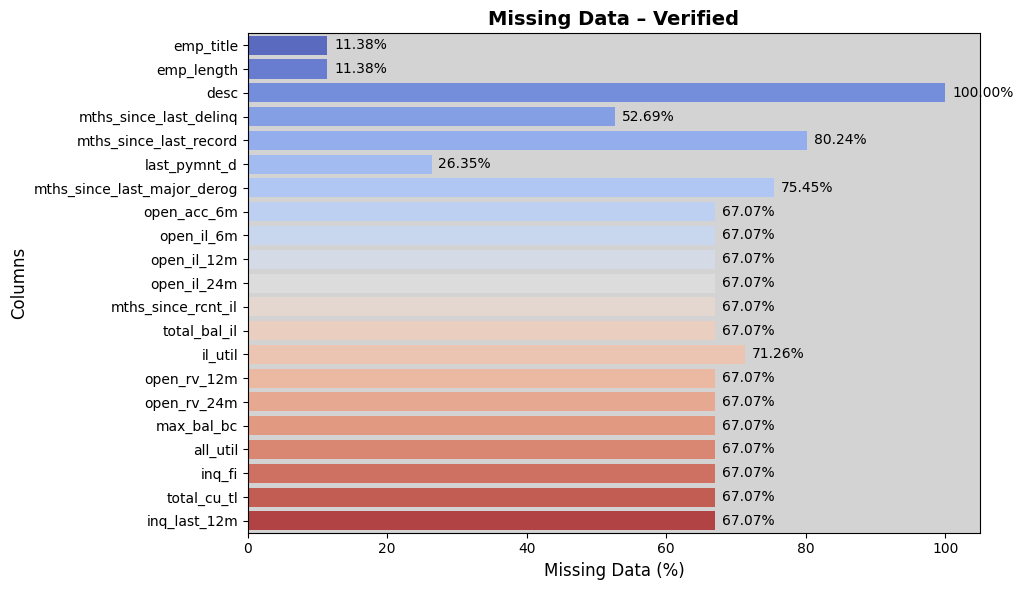

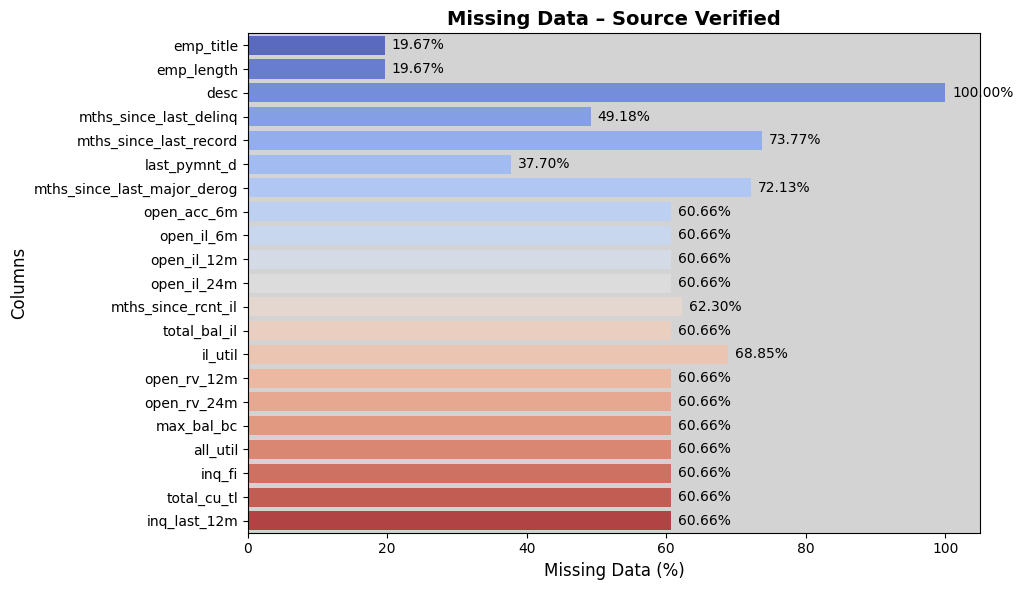

In [ ]:
def plot_missing_data_for_verification_status(df, verification_status, threshold=5, figsize=(10, 6)):

    # Check if required column exists
    if 'verification_status_joint' not in df.columns:
        raise ValueError("Missing 'verification_status_joint' column.")

    # Filter rows by selected verification status
    filtered_df = df[df['verification_status_joint'] == verification_status]

    # Calculate missing value percentages
    missing_percentages = filtered_df.isna().mean() * 100
    missing_percentages = missing_percentages[missing_percentages > threshold]

    # Exit if no columns exceed the missing value threshold
    if missing_percentages.empty:
        print(f"No columns with >{threshold}% missing for '{verification_status}'.")
        return

    # Prepare data for plotting
    plt.figure(figsize=figsize)
    missing_df = pd.DataFrame({
        'column': missing_percentages.index,
        'missing_percent': missing_percentages.values
    })

    # Plot bar chart
    ax = sns.barplot(
        data=missing_df,
        x='missing_percent',
        y='column',
        hue='column',
        palette='coolwarm',
        dodge=False,
        legend=False
    )

    # Add plot labels and formatting
    plt.xlabel('Missing Data (%)', fontsize=12)
    plt.ylabel('Columns', fontsize=12)
    plt.title(f'Missing Data – {verification_status}', fontsize=14, fontweight='bold')
    plt.gca().set_facecolor('lightgray')
    plt.tight_layout()

    # Add data labels to bars
    for p in ax.patches:
        ax.text(p.get_width() + 1, p.get_y() + p.get_height() / 2,
                f'{p.get_width():.2f}%', fontsize=10, color='black',
                ha='left', va='center')

    plt.show()

# Run the function for each verification status
for status in ['Not Verified', 'Verified', 'Source Verified']:
    try:
        plot_missing_data_for_verification_status(df, verification_status=status, threshold=5)
    except Exception as e:
        print(f"Error for '{status}': {e}")

*   **Plot missing data by application_type:**



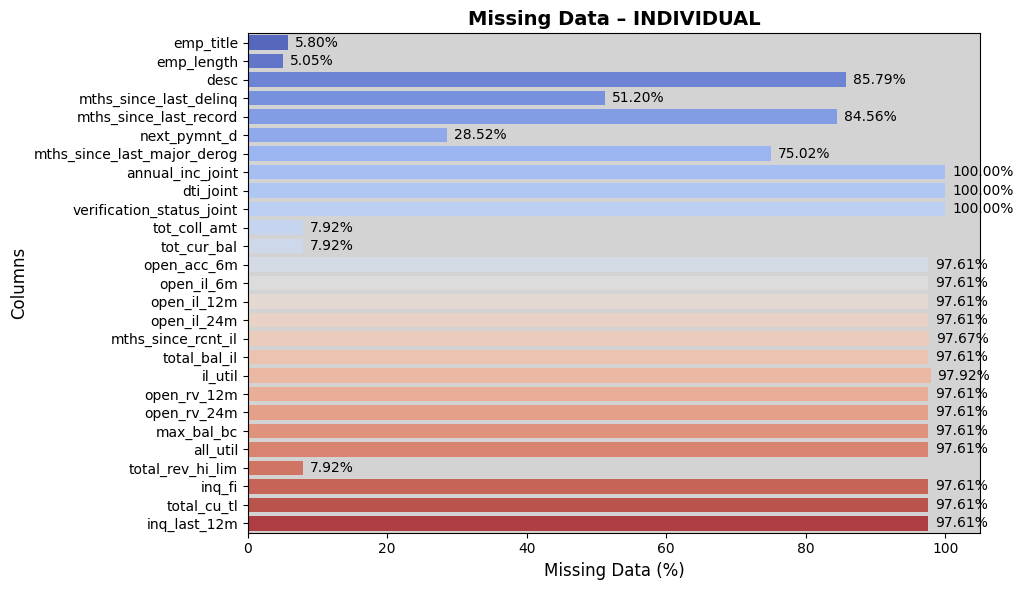

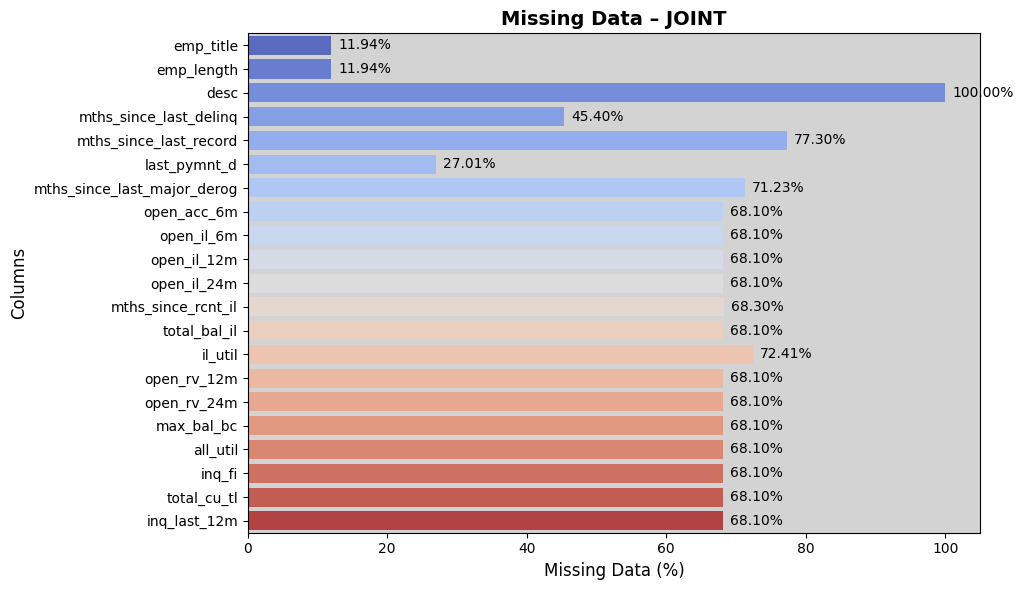

In [ ]:
def plot_missing_data_for_application_type(df, application_type, threshold=5, figsize=(10, 6)):

    # Check if 'application_type' column exists
    if 'application_type' not in df.columns:
        raise ValueError("Missing 'application_type' column.")

    # Filter DataFrame by application type
    filtered_df = df[df['application_type'] == application_type]

    # Calculate missing value percentages
    missing_percentages = filtered_df.isna().mean() * 100
    missing_percentages = missing_percentages[missing_percentages > threshold]

    # Exit if no missing values above threshold
    if missing_percentages.empty:
        print(f"No columns with >{threshold}% missing for '{application_type}'.")
        return

    # Prepare data for plotting
    plt.figure(figsize=figsize)
    missing_df = pd.DataFrame({
        'column': missing_percentages.index,
        'missing_percent': missing_percentages.values
    })

    # Plot bar chart
    ax = sns.barplot(
        data=missing_df,
        x='missing_percent',
        y='column',
        hue='column',
        palette='coolwarm',
        dodge=False,
        legend=False
    )

    # Add labels and formatting
    plt.xlabel('Missing Data (%)', fontsize=12)
    plt.ylabel('Columns', fontsize=12)
    plt.title(f'Missing Data – {application_type}', fontsize=14, fontweight='bold')
    plt.gca().set_facecolor('lightgray')
    plt.tight_layout()

    # Annotate bars with values
    for p in ax.patches:
        ax.text(p.get_width() + 1, p.get_y() + p.get_height() / 2,
                f'{p.get_width():.2f}%', fontsize=10, color='black',
                ha='left', va='center')

    plt.show()

# Run for each application type
for app_type in ['INDIVIDUAL', 'JOINT']:
    try:
        plot_missing_data_for_application_type(df, application_type=app_type, threshold=5)
    except Exception as e:
        print(f"Error for '{app_type}': {e}")

*   **Plot missing data by 'initial_list_status':**

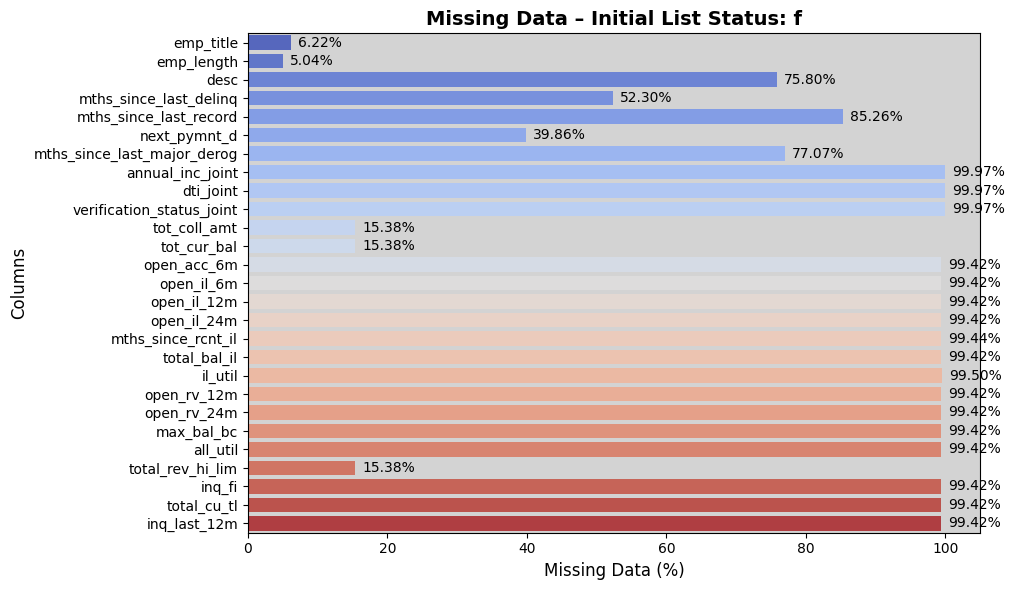

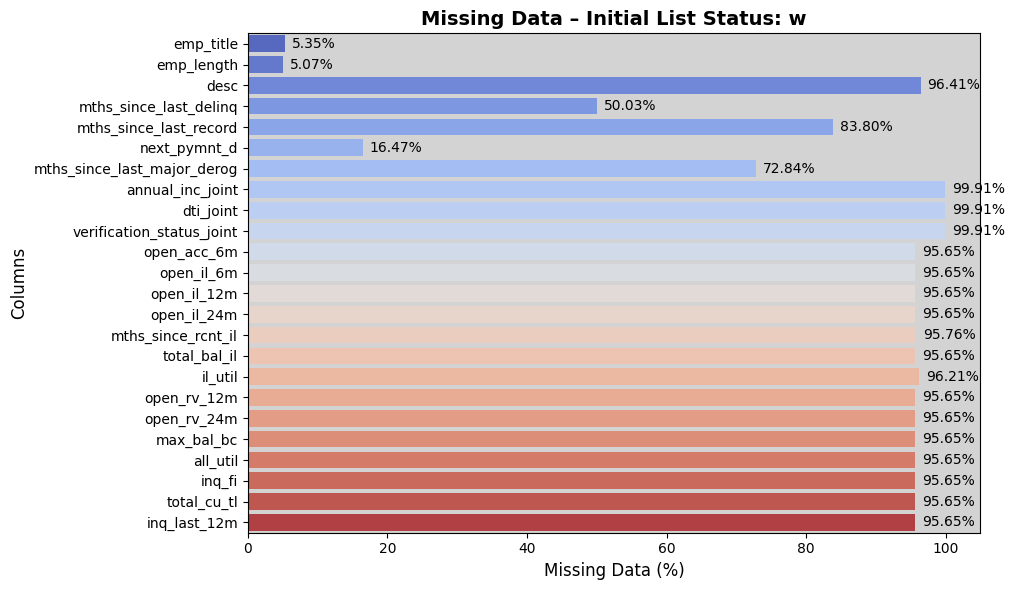

In [ ]:
def plot_missing_data_for_initial_list_status(df, list_status, threshold=5, figsize=(10, 6)):

    # Check if 'initial_list_status' exists
    if 'initial_list_status' not in df.columns:
        raise ValueError("Missing 'initial_list_status' column.")

    # Filter DataFrame by list status
    filtered_df = df[df['initial_list_status'] == list_status]

    # Calculate missing value percentages
    missing_percentages = filtered_df.isna().mean() * 100
    missing_percentages = missing_percentages[missing_percentages > threshold]

    # Exit if no missing values above threshold
    if missing_percentages.empty:
        print(f"No columns with >{threshold}% missing for list status '{list_status}'.")
        return

    # Prepare data for plot
    plt.figure(figsize=figsize)
    missing_df = pd.DataFrame({
        'column': missing_percentages.index,
        'missing_percent': missing_percentages.values
    })

    # Plot bar chart
    ax = sns.barplot(
        data=missing_df,
        x='missing_percent',
        y='column',
        hue='column',
        palette='coolwarm',
        dodge=False,
        legend=False
    )

    # Add labels and formatting
    plt.xlabel('Missing Data (%)', fontsize=12)
    plt.ylabel('Columns', fontsize=12)
    plt.title(f'Missing Data – Initial List Status: {list_status}', fontsize=14, fontweight='bold')
    plt.gca().set_facecolor('lightgray')
    plt.tight_layout()

    # Annotate bars
    for p in ax.patches:
        ax.text(p.get_width() + 1, p.get_y() + p.get_height() / 2,
                f'{p.get_width():.2f}%', fontsize=10, color='black',
                ha='left', va='center')

    plt.show()

# Run for each initial list status
for status in ['f', 'w']:
    try:
        plot_missing_data_for_initial_list_status(df, list_status=status, threshold=5)
    except Exception as e:
        print(f"Error for list status '{status}': {e}")

*   **Plot missing data by 'loan term':**

In [ ]:
def plot_missing_data_for_term(df, term_value, threshold=5, figsize=(10, 6)):

    # Check if 'term' column exists
    if 'term' not in df.columns:
        raise ValueError("Missing 'term' column.")

    # Filter DataFrame by term
    filtered_df = df[df['term'] == term_value]

    # Calculate missing value percentages
    missing_percentages = filtered_df.isna().mean() * 100
    missing_percentages = missing_percentages[missing_percentages > threshold]

    # Exit if no missing values above threshold
    if missing_percentages.empty:
        print(f"No columns with >{threshold}% missing for term '{term_value}'.")
        return

    # Prepare data for plot
    plt.figure(figsize=figsize)
    missing_df = pd.DataFrame({
        'column': missing_percentages.index,
        'missing_percent': missing_percentages.values
    })

    # Plot bar chart
    ax = sns.barplot(
        data=missing_df,
        x='missing_percent',
        y='column',
        hue='column',
        palette='coolwarm',
        dodge=False,
        legend=False
    )

    # Add labels and formatting
    plt.xlabel('Missing Data (%)', fontsize=12)
    plt.ylabel('Columns', fontsize=12)
    plt.title(f'Missing Data – Term: {term_value}', fontsize=14, fontweight='bold')
    plt.gca().set_facecolor('lightgray')
    plt.tight_layout()

    # Annotate bars
    for p in ax.patches:
        ax.text(p.get_width() + 1, p.get_y() + p.get_height() / 2,
                f'{p.get_width():.2f}%', fontsize=10, color='black',
                ha='left', va='center')

    plt.show()

# Run for each term value
for term in ['36 months', '60 months']:
    try:
        plot_missing_data_for_term(df, term_value=term, threshold=5)
    except Exception as e:
        print(f"Error for term '{term}': {e}")

No columns with >5% missing for term '36 months'.
No columns with >5% missing for term '60 months'.


In [ ]:
# DataFrame shape
print(f"\nShape: {df.shape}")


Shape: (887379, 74)


Exclude 'JOINT' applications due to significantly different missing data patterns compared to 'INDIVIDUAL':

In [ ]:
# Filter out JOINT application_type
df = df[df['application_type'] != 'JOINT']

In [ ]:
# DataFrame shape
print(f"\nShape: {df.shape}")


Shape: (886868, 74)


Drop 'application_type' and related 'joint' columns to avoid bias and redundancy after excluding 'JOINT' entries:

In [ ]:
# Drop columns containing 'joint' and 'application_type'
columns_to_drop = [col for col in df.columns if 'joint' in col] + ['application_type']
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# DataFrame shape
print(f"\nShape: {df.shape}")


Shape: (886868, 70)


######<font color="2980B9"><b>PDF Report: "Distribution in columns.pdf" - Value Distribution with Frequencies, Percentages, and Bar Plots</b></font>

Generates a PDF report titled 'Distribution in columns.pdf' that visualizes the value distribution of each DataFrame column. For each column, it includes frequencies, percentages, and corresponding bar plots. The function allows limiting the number of displayed values (top_n) and sorting the results in ascending or descending order.

In [ ]:
def show_value_distribution_visual_to_pdf(df, top_n=10, ascending=False, pdf_filename="Distribution in columns.pdf"):
    # Create PDF canvas
    c = canvas.Canvas(pdf_filename, pagesize=letter)
    width, height = letter
    c.setFont("Helvetica", 6)

    # Title and initial position
    c.drawString(100, height - 40, "Displaying full value distribution by column")
    y_position = height - 60

    # Iterate through columns
    for column in df.columns:
        if y_position < 100:  # New page if space is low
            c.showPage()
            y_position = height - 40
            c.setFont("Helvetica", 8)
            c.drawString(100, y_position, "Displaying value distribution")
            y_position -= 20

        c.setFont("Helvetica", 6)
        c.drawString(100, y_position, f"Showing distribution in '{column}':")
        y_position -= 20

        # Calculate value counts and percentages
        value_counts = df[column].value_counts(dropna=False)
        percentage = (value_counts / len(df)) * 100
        if top_n:
            value_counts = value_counts.head(top_n)
            percentage = (value_counts / len(df)) * 100

        # Write frequency and percentage
        for value, count, perc in zip(value_counts.index, value_counts.values, percentage):
            text = f"'{value}': {count} times, {perc:.2f}%"
            if y_position < 100:  # New page if space is low
                c.showPage()
                y_position = height - 40
                c.setFont("Helvetica", 6)
            c.drawString(100, y_position, text)
            y_position -= 12

        # Sort and plot values
        value_counts = value_counts.sort_values(ascending=ascending)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=value_counts.index.astype(str), y=value_counts.values, hue=value_counts.index.astype(str), palette="Blues_d", legend=False)
        plt.title(f"Distribution in '{column}'")
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)

        # Save and add plot to PDF
        plot_image = f"{column}_distribution.png"
        plt.savefig(plot_image, bbox_inches="tight")
        plt.close()

        if y_position < 250:  # New page if space is low
            c.showPage()
            y_position = height - 40
            c.setFont("Helvetica", 6)
        c.drawImage(plot_image, 100, y_position - 200, width=400, height=200)
        y_position -= 220

        # Remove temporary plot image
        os.remove(plot_image)

    # Save PDF
    c.save()

In [ ]:
# Call the function to generate the PDF
show_value_distribution_visual_to_pdf(df)

In [ ]:
# Download the generated PDF
files.download("Distribution in columns.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

######<font color="2980B9"><b>Missing Value Analysis and Removal of Columns with Over 20% Missing Data</b></font>

Performs a missing data analysis by calculating the percentage of null values in each column. Columns with more than 5% missing values are visualized in a horizontal bar chart to identify potential data quality issues. Subsequently, columns exceeding 20% missing values are removed from the DataFrame to enhance the robustness of subsequent analyses.

In [ ]:
# Calculate the percentage of null values per column
null_percentages = df.isnull().mean() * 100

In [ ]:
# Iterate through columns with null values
for column, percentage in null_percentages.items():
    if percentage > 0:
        print(f"{column: <30}: {round(percentage, 2): <6}%  |  Type: {df[column].dtype}")

emp_title                     : 5.8   %  |  Type: object
emp_length                    : 5.05  %  |  Type: object
annual_inc                    : 0.0   %  |  Type: float64
desc                          : 85.79 %  |  Type: object
title                         : 0.02  %  |  Type: object
delinq_2yrs                   : 0.0   %  |  Type: float64
earliest_cr_line              : 0.0   %  |  Type: object
inq_last_6mths                : 0.0   %  |  Type: float64
mths_since_last_delinq        : 51.2  %  |  Type: float64
mths_since_last_record        : 84.56 %  |  Type: float64
open_acc                      : 0.0   %  |  Type: float64
pub_rec                       : 0.0   %  |  Type: float64
revol_util                    : 0.06  %  |  Type: float64
total_acc                     : 0.0   %  |  Type: float64
last_pymnt_d                  : 1.98  %  |  Type: object
next_pymnt_d                  : 28.52 %  |  Type: object
last_credit_pull_d            : 0.01  %  |  Type: object
collections_12_mths_ex

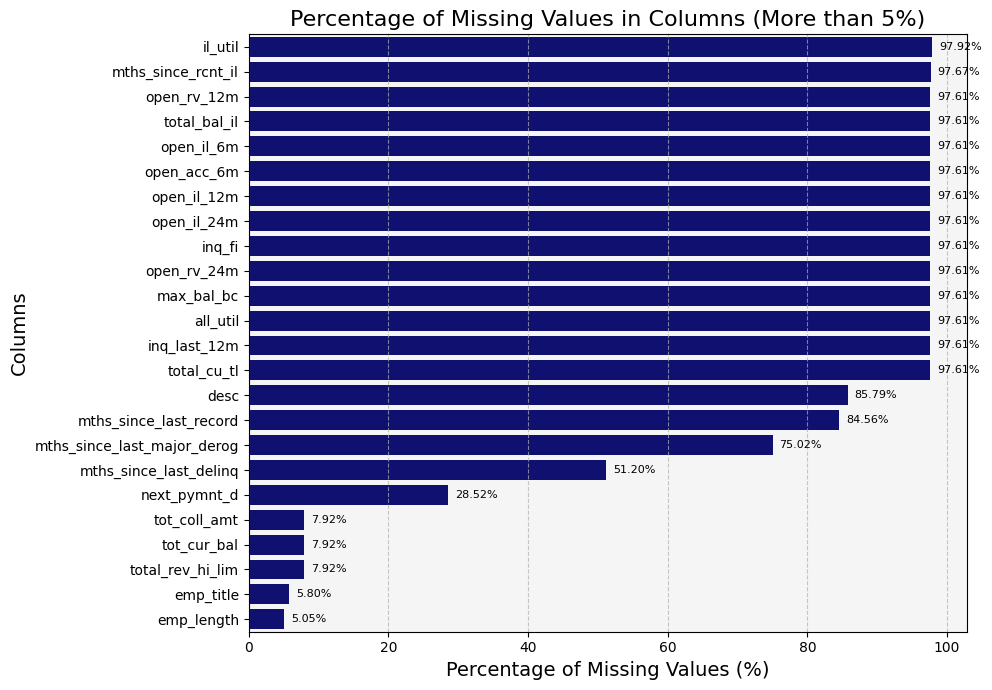

In [ ]:
# Calculate and filter columns with more than 5% missing values
filtered_columns = df.isnull().mean() * 100
filtered_columns = filtered_columns[filtered_columns > 5].sort_values(ascending=False)

# Plot missing data percentages
plt.figure(figsize=(10, 7))
sns.barplot(y=filtered_columns.index, x=filtered_columns.values, color='navy', orient='h', width=0.8)

# Annotate bars with percentage values
for idx, value in enumerate(filtered_columns.values):
    plt.text(value + 1, idx, f'{value:.2f}%', va='center', fontsize=8)

# Customize and display plot
plt.title('Percentage of Missing Values in Columns (More than 5%)', fontsize=16)
plt.xlabel('Percentage of Missing Values (%)', fontsize=14)
plt.ylabel('Columns', fontsize=14)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()

In [ ]:
# DataFrame shape
print(f"\nShape: {df.shape}")


Shape: (886868, 70)


In [ ]:
# Identify columns with more than 20% missing values
columns_to_drop = [col for col in df.columns if df[col].isna().mean() * 100 > 20]

In [ ]:
# Print the columns that will be dropped
print("Columns to drop:", columns_to_drop)

Columns to drop: ['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']


The following columns, each containing more than 20% missing values, have been excluded:

'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d',
'mths_since_last_major_derog', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m'

In [ ]:
# Drop columns with more than 20% missing values
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# DataFrame shape
print(f"\nShape: {df.shape}")


Shape: (886868, 51)


######<font color="2980B9"><b>Analysis of Unique Values and Removal of Specific Columns</b></font>

The code performs the following:

1. Displays the count of unique values for each column.
2. Identifies and visualizes columns with fewer than 10 unique values.
3. Removes columns `'pymnt_plan'`, `'policy_code'`, and `'acc_now_delinq'`.

It sorts the columns by unique value count in descending order, highlighting those with limited unique entries.

In [ ]:
# Display the number of unique values for each column
for col in sorted(df.columns, key=lambda x: df[x].nunique(), reverse=True):
    print(f"{col: <30}: {df[col].nunique():^5}")

id                            : 886868
member_id                     : 886868
url                           : 886868
total_pymnt                   : 506637
total_pymnt_inv               : 506515
tot_cur_bal                   : 327230
total_rec_int                 : 324623
emp_title                     : 299159
out_prncp_inv                 : 266137
total_rec_prncp               : 260185
out_prncp                     : 248246
last_pymnt_amnt               : 232437
revol_bal                     : 73738
installment                   : 68701
title                         : 63143
annual_inc                    : 49345
recoveries                    : 23055
total_rev_hi_lim              : 21249
collection_recovery_fee       : 20708
tot_coll_amt                  : 10321
funded_amnt_inv               : 9856 
total_rec_late_fee            : 6181 
dti                           : 4000 
loan_amnt                     : 1372 
funded_amnt                   : 1372 
revol_util                    : 1356 


The code is looping through each column in the DataFrame and checking if it has fewer than 10 unique values. If so, it is printing the column name followed by the value counts for that column in a cleaner format. This helps in identifying columns with fewer unique values and displaying the distribution of their data:

**Drop columns with limited analytical value or redundancy:**

In [ ]:
# Display value counts for columns with fewer than 10 unique values
for col in df.columns:
    if df[col].nunique() < 10:
        print(f"\nColumn: {col}")
        print(df[col].value_counts())


Column: term
term
36 months    620886
60 months    265982
Name: count, dtype: int64

Column: grade
grade
B    254433
C    245717
A    148184
D    139419
E     70614
F     23022
G      5479
Name: count, dtype: int64

Column: home_ownership
home_ownership
MORTGAGE    443203
RENT        355995
OWN          87435
OTHER          182
NONE            50
ANY              3
Name: count, dtype: int64

Column: verification_status
verification_status
Source Verified    329424
Verified           290810
Not Verified       266634
Name: count, dtype: int64

Column: pymnt_plan
pymnt_plan
n    886858
y        10
Name: count, dtype: int64

Column: initial_list_status
initial_list_status
f    456703
w    430165
Name: count, dtype: int64

Column: policy_code
policy_code
1.00000    886868
Name: count, dtype: int64

Column: acc_now_delinq
acc_now_delinq
0.00000     882726
1.00000       3865
2.00000        208
3.00000         28
4.00000          7
5.00000          3
6.00000          1
14.00000         1
Name

In [ ]:
# Remove specified columns from the DataFrame
df.drop(columns=['pymnt_plan', 'policy_code', 'acc_now_delinq'], inplace=True)

In [ ]:
# DataFrame shape
print(f"\nShape: {df.shape}")


Shape: (886868, 48)


######<font color="2980B9"><b>Analysis of 'grade' and 'sub_grade'</b></font>

In [ ]:
# Display the first 5 rows of 'grade' and 'sub_grade' columns
df[['grade', 'sub_grade']].head()

,grade,sub_grade
0,B,B2
1,C,C4
2,C,C5
3,C,C1
4,B,B5


In [ ]:
# Display sorted unique values of 'sub_grade'
print("\nSorted unique sub_grades:\n", sorted(df['sub_grade'].dropna().unique()))


Sorted unique sub_grades:
 ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


######<font color="2980B9"><b>Dropping Uninformative or Redundant Columns</b></font>

The following columns are dropped from the DataFrame due to their redundancy or lack of relevance: 'id', 'member\_id', 'url', 'issue\_d', 'earliest\_cr\_line', 'grade', 'last\_credit\_pull\_d', 'emp\_title', 'title', 'zip\_code', 'addr\_state', and 'last\_pymnt\_d':

In [ ]:
df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000.00000,5000.00000,4975.00000,36 months,10.65000,162.87000,B,B2,...,0.00000,0.00000,0.00000,Jan-2015,171.62000,Jan-2016,0.00000,NaN,NaN,NaN
1,1077430,1314167,2500.00000,2500.00000,2500.00000,60 months,15.27000,59.83000,C,C4,...,0.00000,117.08000,1.11000,Apr-2013,119.66000,Sep-2013,0.00000,NaN,NaN,NaN
2,1077175,1313524,2400.00000,2400.00000,2400.00000,36 months,15.96000,84.33000,C,C5,...,0.00000,0.00000,0.00000,Jun-2014,649.91000,Jan-2016,0.00000,NaN,NaN,NaN


In [ ]:
# DataFrame shape
print(f"\nShape: {df.shape}")


Shape: (886868, 48)


In [ ]:
df.drop(columns=['id', 'member_id', 'url', 'issue_d', 'earliest_cr_line', 'grade', 'last_credit_pull_d'], inplace=True)

In [ ]:
df.drop(columns=['emp_title', 'title', 'zip_code', 'addr_state', 'last_pymnt_d'], inplace=True)

In [ ]:
# DataFrame shape
print(f"\nShape: {df.shape}")


Shape: (886868, 36)


In [ ]:
df.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000.00000,5000.00000,4975.00000,36 months,10.65000,162.87000,B2,10+ years,RENT,24000.00000,...,5000.00000,861.07000,0.00000,0.00000,0.00000,171.62000,0.00000,NaN,NaN,NaN
1,2500.00000,2500.00000,2500.00000,60 months,15.27000,59.83000,C4,< 1 year,RENT,30000.00000,...,456.46000,435.17000,0.00000,117.08000,1.11000,119.66000,0.00000,NaN,NaN,NaN
2,2400.00000,2400.00000,2400.00000,36 months,15.96000,84.33000,C5,10+ years,RENT,12252.00000,...,2400.00000,603.65000,0.00000,0.00000,0.00000,649.91000,0.00000,NaN,NaN,NaN


######<font color="2980B9"><b>Employment Length vs. Loan Status — Analysis and Column Removal</b></font>

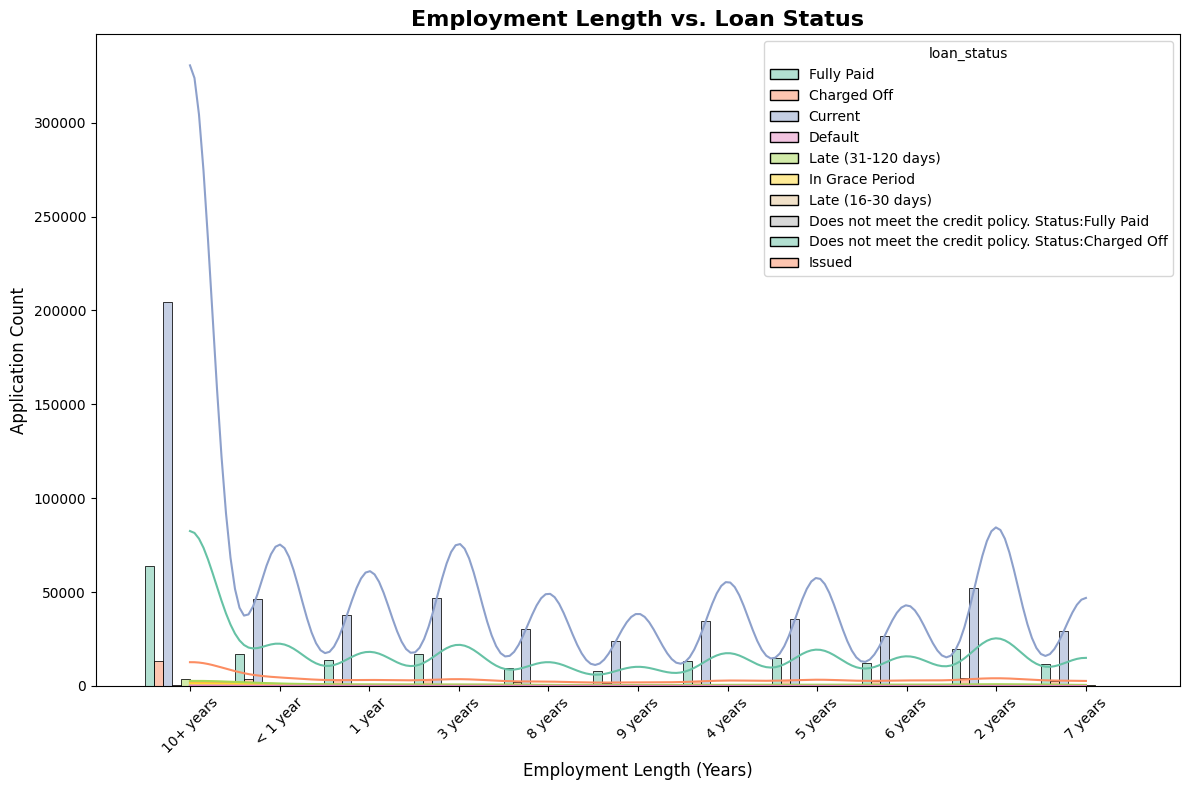

In [ ]:
# Plot: Employment Length vs. Loan Status
plt.figure(figsize=(12, 8))
sns.histplot(
    data=df,
    x="emp_length",
    hue="loan_status",
    multiple="dodge",
    palette="Set2",
    kde=True,
    bins=30
)
plt.title("Employment Length vs. Loan Status", fontsize=16, fontweight='bold')
plt.xlabel("Employment Length (Years)", fontsize=12)
plt.ylabel("Application Count", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Drop 'emp_length' due to low predictive relevance
df.drop(columns=['emp_length'], inplace=True)

In [ ]:
# DataFrame shape
print(f"\nShape: {df.shape}")


Shape: (886868, 35)


In [ ]:
# Store current column names as important features
important_features = df.columns

######<font color="2980B9"><b>Handling Missing Values: Selective Row Removal for Low Null Percentages</b></font>

If a column has less than 1% missing values, it removes only those specific rows.

In [ ]:
# Percentage of missing values per column
na_percentages = df.isna().mean() * 100

In [ ]:
# Display columns with missing values and their data types
for col, pct in na_percentages.items():
    if pct > 0:
        print(f"{col:<30}: {pct:.2f}%  |  Type: {df[col].dtype}")

annual_inc                    : 0.00%  |  Type: float64
delinq_2yrs                   : 0.00%  |  Type: float64
inq_last_6mths                : 0.00%  |  Type: float64
open_acc                      : 0.00%  |  Type: float64
pub_rec                       : 0.00%  |  Type: float64
revol_util                    : 0.06%  |  Type: float64
total_acc                     : 0.00%  |  Type: float64
collections_12_mths_ex_med    : 0.02%  |  Type: float64
tot_coll_amt                  : 7.92%  |  Type: float64
tot_cur_bal                   : 7.92%  |  Type: float64
total_rev_hi_lim              : 7.92%  |  Type: float64


In [ ]:
# Print initial shape
print(f"\nInitial DataFrame shape: {df.shape}")

# Drop rows with missing values in columns where missing rate is under 1%
df.dropna(subset=na_percentages[na_percentages < 1].index, inplace=True)

# Print shape after cleanup
print(f"\nPost-cleaning DataFrame shape: {df.shape}")


Initial DataFrame shape: (886868, 35)

Post-cleaning DataFrame shape: (886253, 35)


####<font color="1F4E79"><b>2.2 Encoding</b></font>

######<font color="2980B9"><b>Pre-encoding</b></font>

In [ ]:
# Select categorical features excluding 'loan_status'
categorical_features = df.select_dtypes(include='object').drop(columns=['loan_status'])

In [ ]:
categorical_features.head(3)

,term,sub_grade,home_ownership,verification_status,purpose,initial_list_status
0,36 months,B2,RENT,Verified,credit_card,f
1,60 months,C4,RENT,Source Verified,car,f
2,36 months,C5,RENT,Not Verified,small_business,f


In [ ]:
# Display value counts for each categorical feature
for col in categorical_features.columns:
    print(f"\n{col}:\n{categorical_features[col].value_counts()}")


term:
term
36 months    620387
60 months    265866
Name: count, dtype: int64

sub_grade:
sub_grade
B3    56283
B4    55568
C1    53329
C2    52179
C3    50097
C4    48785
B5    48774
B2    48748
B1    44951
A5    44791
C5    41168
D1    36164
A4    34511
D2    29754
D3    26507
D4    25506
A3    23444
A1    22907
A2    22467
D5    21345
E1    18234
E2    16960
E3    14105
E4    11687
E5     9542
F1     7203
F2     5374
F3     4422
F4     3399
F5     2589
G1     1864
G2     1388
G3      978
G4      659
G5      571
Name: count, dtype: int64

home_ownership:
home_ownership
MORTGAGE    442916
RENT        355748
OWN          87362
OTHER          180
NONE            44
ANY              3
Name: count, dtype: int64

verification_status:
verification_status
Source Verified    329259
Verified           290635
Not Verified       266359
Name: count, dtype: int64

purpose:
purpose
debt_consolidation    523642
credit_card           205989
home_improvement       51724
other                  42760
ma

######<font color="2980B9"><b>Encoding 'sub_grade'</b></font>

In [ ]:
df['sub_grade'].unique()

array(['B2', 'C4', 'C5', 'C1', 'B5', 'A4', 'E1', 'F2', 'C3', 'B1', 'D1',
       'A1', 'B3', 'B4', 'C2', 'D2', 'A3', 'A5', 'D5', 'A2', 'E4', 'D3',
       'D4', 'F3', 'E3', 'F4', 'F1', 'E5', 'G4', 'E2', 'G3', 'G2', 'G1',
       'F5', 'G5'], dtype=object)

In [ ]:
def encode_sub_grade(x):
    grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
    suffix_mapping = {'1': 0.8, '2': 0.6, '3': 0.4, '4': 0.2, '5': 0.0}

    grade = next((v for k, v in grade_mapping.items() if k in x), 0)
    suffix = next((v for k, v in suffix_mapping.items() if k in x), 0)

    return grade + suffix

In [ ]:
# Encode 'sub_grade' using the custom encoding function
df['sub_grade'] = df['sub_grade'].apply(encode_sub_grade)

In [ ]:
df['sub_grade'].unique()

array([6.6, 5.2, 5. , 5.8, 6. , 7.2, 3.8, 2.6, 5.4, 6.8, 4.8, 7.8, 6.4,
       6.2, 5.6, 4.6, 7.4, 7. , 4. , 7.6, 3.2, 4.4, 4.2, 2.4, 3.4, 2.2,
       2.8, 3. , 1.2, 3.6, 1.4, 1.6, 1.8, 2. , 1. ])

######<font color="2980B9"><b>Encoding 'term'</b></font>

In [ ]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode 'term' and 'initial_list_status' columns as numeric values
df['term'] = label_encoder.fit_transform(df['term'])
df['initial_list_status'] = label_encoder.fit_transform(df['initial_list_status'])

In [ ]:
df['term'].unique()

array([0, 1])

######<font color="2980B9"><b>Encoding 'verification_status'</b></font>

In [ ]:
df['verification_status'].unique()

array(['Verified', 'Source Verified', 'Not Verified'], dtype=object)

In [ ]:
# Function to encode verification status
def verification_status(x):
    return 0 if x == 'Not Verified' else 1

In [ ]:
df['verification_status'] = df['verification_status'].apply(verification_status)

In [ ]:
df['verification_status'].unique()

array([1, 0])

In [ ]:
categorical_features = df.select_dtypes(include='object').drop(columns=['loan_status'])

In [ ]:
categorical_features.head(3)

,home_ownership,purpose
0,RENT,credit_card
1,RENT,car
2,RENT,small_business


In [ ]:
# Check for missing values in categorical features
categorical_features.isna().sum()

,0
home_ownership,0
purpose,0


In [ ]:
# One-hot encoded categorical features to convert them into numeric form
encoded_features = pd.get_dummies(categorical_features, dtype=int)

encoded_features.head(3)

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Add the one-hot encoded categorical features back to the original DataFrame
df = pd.concat([df, encoded_features], axis=1)

In [ ]:
# Drop the original categorical columns after one-hot encoding to avoid redundancy
df.drop(columns=categorical_features.columns, inplace=True)

df.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,annual_inc,verification_status,loan_status,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,5000.00000,5000.00000,4975.00000,0,10.65000,162.87000,6.60000,24000.00000,1,Fully Paid,...,0,0,0,0,0,0,0,0,0,0
1,2500.00000,2500.00000,2500.00000,1,15.27000,59.83000,5.20000,30000.00000,1,Charged Off,...,0,0,0,0,0,0,0,0,0,0
2,2400.00000,2400.00000,2400.00000,0,15.96000,84.33000,5.00000,12252.00000,0,Fully Paid,...,0,0,0,0,0,0,0,1,0,0


####<font color="1F4E79"><b>2.3 Handling Missing Values</b></font>

In [ ]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,annual_inc,verification_status,loan_status,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,5000.00000,5000.00000,4975.00000,0,10.65000,162.87000,6.60000,24000.00000,1,Fully Paid,...,0,0,0,0,0,0,0,0,0,0
1,2500.00000,2500.00000,2500.00000,1,15.27000,59.83000,5.20000,30000.00000,1,Charged Off,...,0,0,0,0,0,0,0,0,0,0
2,2400.00000,2400.00000,2400.00000,0,15.96000,84.33000,5.00000,12252.00000,0,Fully Paid,...,0,0,0,0,0,0,0,1,0,0
3,10000.00000,10000.00000,10000.00000,0,13.49000,339.31000,5.80000,49200.00000,1,Fully Paid,...,0,0,0,0,0,1,0,0,0,0
4,3000.00000,3000.00000,3000.00000,1,12.69000,67.79000,6.00000,80000.00000,1,Current,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# Display columns with missing values
df.isna().sum()[df.isna().sum() > 0]

,0
tot_coll_amt,70042
tot_cur_bal,70042
total_rev_hi_lim,70042


In [ ]:
# Remove rows with missing values and verify no nulls remain
df = df.dropna()
print(df.isna().sum())

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
sub_grade                     0
annual_inc                    0
verification_status           0
loan_status                   0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_pymnt_inv               0
total_rec_prncp               0
total_rec_int                 0
total_rec_late_fee            0
recoveries                    0
collection_recovery_fee       0
last_pymnt_amnt               0
collections_12_mths_ex_med    0
tot_coll_amt                  0
tot_cur_

####<font color="1F4E79"><b>2.4 Encoding Target Variable -> 'loan_status'</b></font>

In the loan_status variable, we filter the data to retain only the categories 'Fully Paid' and 'Charged Off'. This ensures we focus solely on the loan outcomes of interest. The loan_status is then encoded as a binary target variable, with 'Fully Paid' mapped to 0 (indicating a fully repaid loan) and 'Charged Off' mapped to 1 (indicating an unpaid or written-off loan). This transformation allows us to represent the loan status as two classes: '0' for paid loans and '1' for unpaid loans, facilitating subsequent analysis and modeling.

In [ ]:
print(df['loan_status'].value_counts())
print(df['loan_status'].unique())

loan_status
Current               597506
Fully Paid            153936
Charged Off            35206
Late (31-120 days)     11460
Issued                  8393
In Grace Period         6182
Late (16-30 days)       2328
Default                 1200
Name: count, dtype: int64
['Current' 'Fully Paid' 'Late (31-120 days)' 'Late (16-30 days)'
 'Charged Off' 'In Grace Period' 'Default' 'Issued']


In [ ]:
# Filter the DataFrame to include only rows where loan_status is 'Fully Paid' or 'Charged Off'
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# Verify the unique values in 'loan_status'
print(df['loan_status'].value_counts())

loan_status
Fully Paid     153936
Charged Off     35206
Name: count, dtype: int64


In [ ]:
# Encode loan_status as a binary target: 1 for 'Charged Off', 0 for 'Fully Paid'
df['loan_status_bin'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

In [ ]:
print(df['loan_status_bin'].value_counts())

loan_status_bin
0    153936
1     35206
Name: count, dtype: int64


###<font color="1F4E79"><b>3. Split Data (train/test) and SMOTE (Synthetic Minority Over-sampling Technique)</font>

In [ ]:
# Define features (X) and target variable (y)
X = df.drop(columns=['loan_status', 'loan_status_bin'])
y = df['loan_status_bin']

# Split the data into 80% training and 20% testing sets, stratified by the target variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Initialize SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)

# Apply SMOTE to oversample the minority class in X_train and y_train
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

###<font color="1F4E79"><b>4. Modeling and Confusion Matrix</font>

Results for RandomForest:
Accuracy: 0.9988368711834835
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30788
           1       1.00      0.99      1.00      7041

    accuracy                           1.00     37829
   macro avg       1.00      1.00      1.00     37829
weighted avg       1.00      1.00      1.00     37829



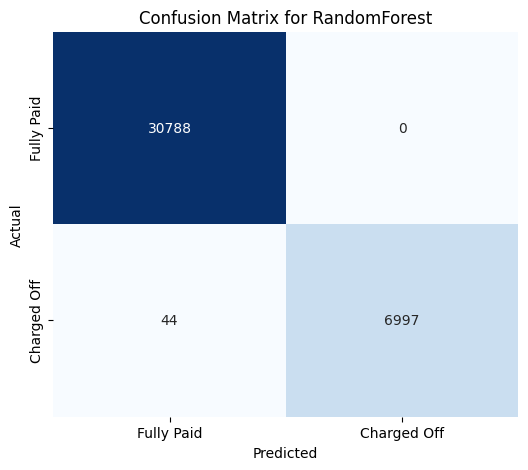

--------------------------------------------------
Results for XGBoost:
Accuracy: 0.999365566100082
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30788
           1       1.00      1.00      1.00      7041

    accuracy                           1.00     37829
   macro avg       1.00      1.00      1.00     37829
weighted avg       1.00      1.00      1.00     37829



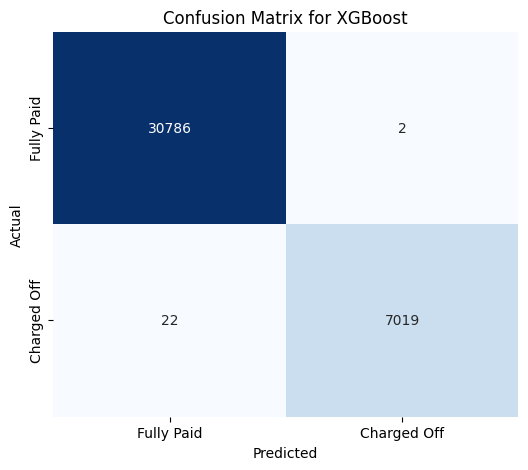

--------------------------------------------------
Results for HistGradientBoosting:
Accuracy: 0.9992333923709323
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30788
           1       1.00      1.00      1.00      7041

    accuracy                           1.00     37829
   macro avg       1.00      1.00      1.00     37829
weighted avg       1.00      1.00      1.00     37829



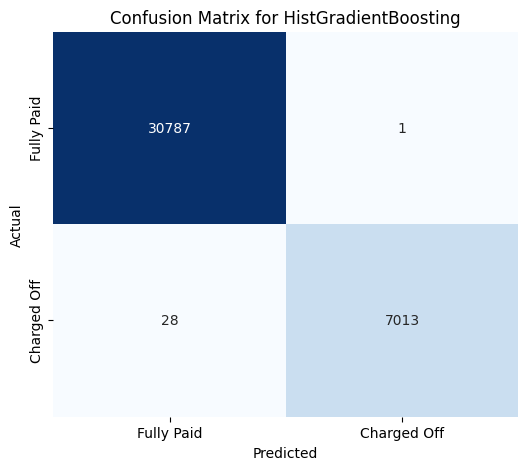

--------------------------------------------------
Results for LogisticRegression:
Accuracy: 0.9985196542335245
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30788
           1       1.00      0.99      1.00      7041

    accuracy                           1.00     37829
   macro avg       1.00      1.00      1.00     37829
weighted avg       1.00      1.00      1.00     37829



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


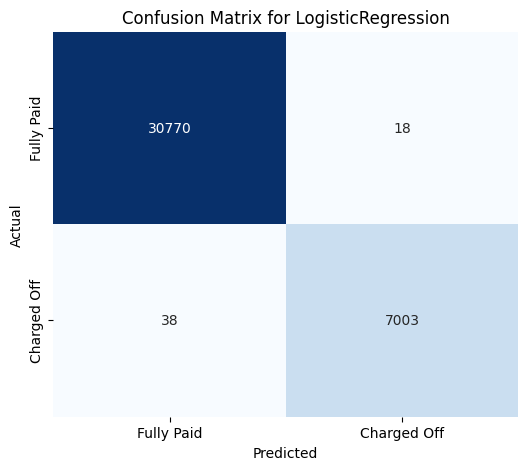

--------------------------------------------------


In [ ]:
# Create a dictionary with the models to evaluate
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=2000)
}

# Iterate through the models, train them, and evaluate their performance
for name, model in models.items():
    # Train the model on the resampled training set
    model.fit(X_train_res, y_train_res)

    # Predict the target on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    print(f"Results for {name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualize the confusion matrix as a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fully Paid', 'Charged Off'], yticklabels=['Fully Paid', 'Charged Off'], cbar=False)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("-" * 50)  # Separator for readability

###<font color="1F4E79"><b>5. Training the Best Model (HistGradientBoosting) and SHAP Interpretation</b></font>

Shapley values as an interpretability technique:

100%|===================| 37762/37829 [02:53<00:00]       

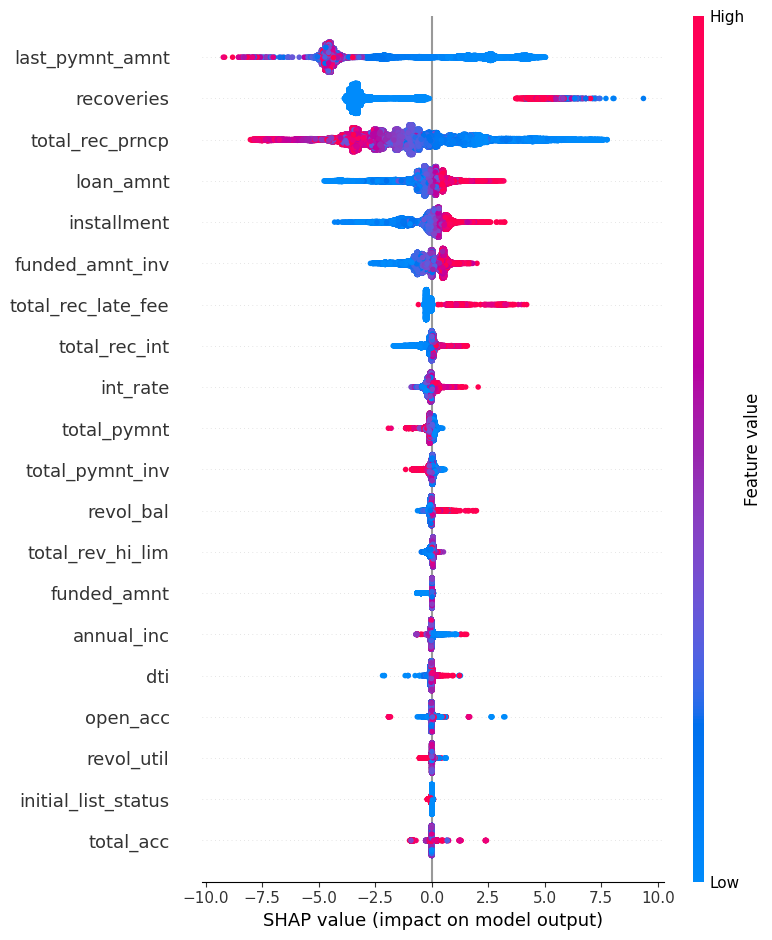

In [ ]:
# Train the HistGradientBoosting model
model = HistGradientBoostingClassifier(random_state=42)
model.fit(X_train_res, y_train_res)

# Create the SHAP explainer for the trained model
explainer = shap.Explainer(model, X_train_res)

# Get SHAP values for the test set
shap_values = explainer(X_test, check_additivity=False)

# Visualize SHAP values for the first 10 predictions
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

Selected Features: 'last_pymnt_amnt', 'recoveries', 'total_rec_prncp',  'loan_amnt', 'installment':

<Figure size 1000x600 with 0 Axes>

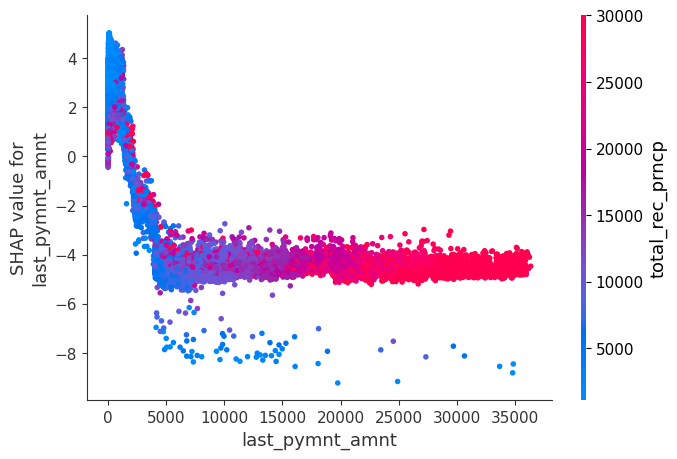

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

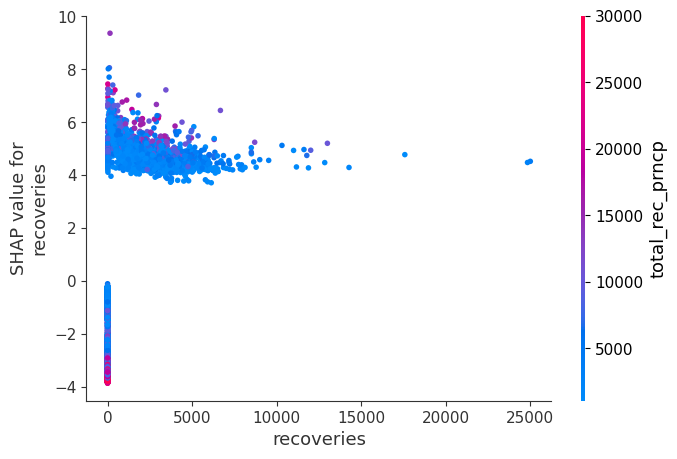

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

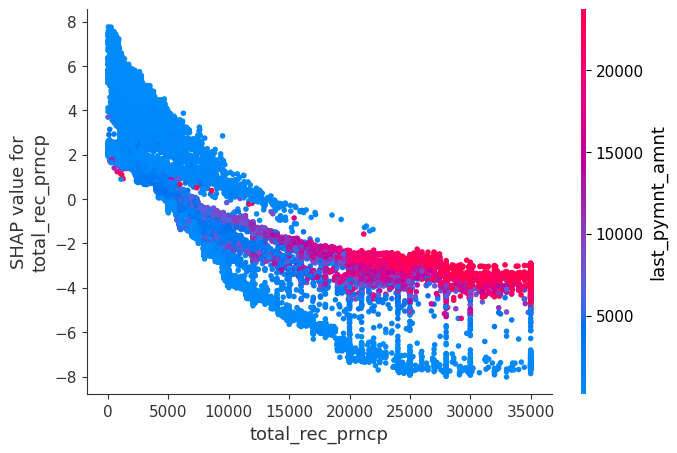

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

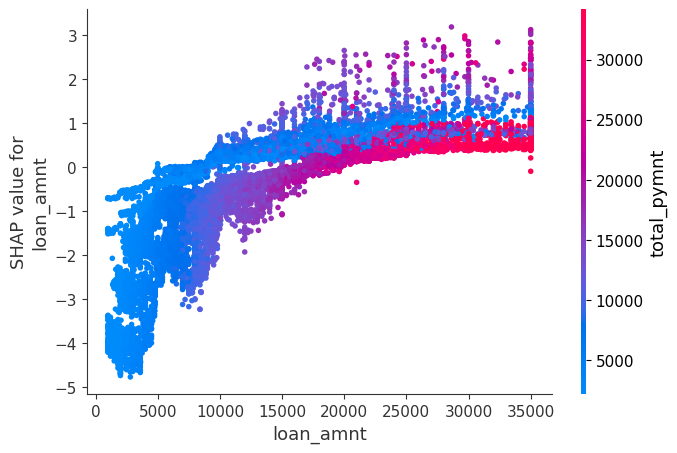

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

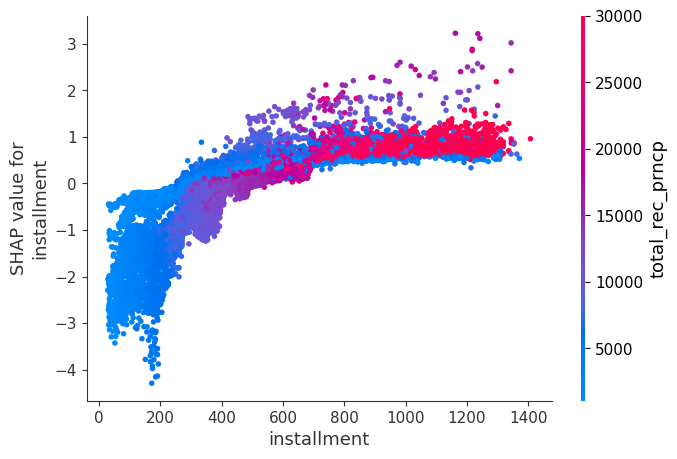

<Figure size 640x480 with 0 Axes>

In [ ]:
# Dependence plots for selected features
features_to_plot = ['last_pymnt_amnt', 'recoveries', 'total_rec_prncp', 'loan_amnt', 'installment']

for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values.values, X_test)
    plt.suptitle(f'Dependence plot for: {feature}', fontsize=14, fontweight='bold')
    plt.show()

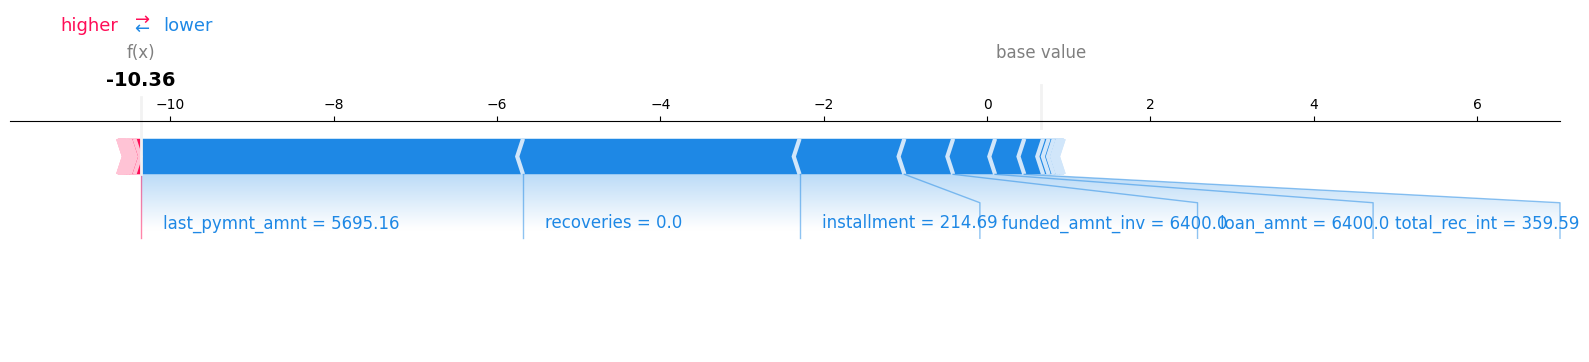

In [ ]:
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test.iloc[0], matplotlib=True)

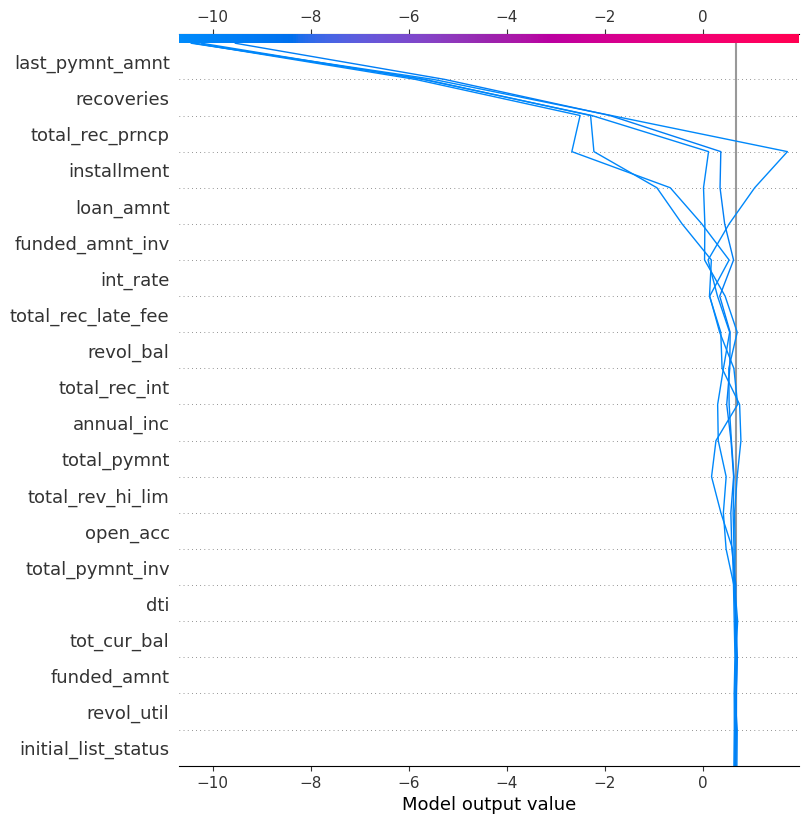

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values.values[:5], X_test.iloc[:5])



---

